Motivation
----------

One of ML features is "auto-response", where the system suggests the next message a representative should send. The representative can opt to use the suggested message, or type out their own. **The more often the representative uses the suggested message the more successful we consider the feature to be.** We track a metric called augmentation rate, which is the percentage of representative sent messages that came from the auto-response system.

Your task is to:
 - analyze the results of an A/B test in which we are testing a new model,
 - evaluate the experimental design, and
 - explain to the product managers what the impact of switching to the new model will be.
 
Goals
-----

1. Data Understanding
    * Give an overview of the dataset that sets the context for the experiment
    * Please keep track of any statistics or findings that you think are relevant to solving the problem.

2. Analyze experimental design
    * What can you infer about the design of the experiment from the dataset?
    * What are the pros/cons of the design, what might you want to change?

3. Analyze the impact of the new model
    * Does the treatment version of the model have an impact on auto-response usage?
    * Can you quantify your uncertaintity about the impact of the new model?
    * What is the expected change in augmentation rate if we switched everyone to the new model?

4. Build a report to present your results
    * The report should be technically rigourous, but accessible to a non-technical audience
    * Document any assumptions you made about the data
    
    
# 1 Data Exploration


In [210]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
import scipy.stats as st

# Data descriptor:
fug = {
    'start_time': 'timestamp',
    'rep_id': 'Representative id',
    'rep_sent_msgs': 'number of messages sent by the representative', 
    'augmented_msgs': 'number of messages accepted by the representative', 
    'treatment': 'whether or not the new model was applied'
}

for k, v in fug.items():
    print(f"{k:20}: {v}")



start_time          : timestamp
rep_id              : Representative id
rep_sent_msgs       : number of messages sent by the representative
augmented_msgs      : number of messages accepted by the representative
treatment           : whether or not the new model was applied


In [168]:

# Reading data:
df = pd.read_csv('./data/data.csv')
df['start_time'] = pd.to_datetime(df['start_time'])
df['augmentation_rate'] = df['augmented_msgs'] / df['rep_sent_msgs']
print(df.shape)
df.head()



(69114, 6)


start_time   rep_id  rep_sent_msgs  augmented_msgs  treatment  \
0 2018-10-15 04:35:36  1160001             12               1      False   
1 2018-10-15 04:34:33  4140001              8               3      False   
2 2018-10-15 04:24:53  4450001             13               2      False   
3 2018-10-15 04:33:34  4140001              9               1      False   
4 2018-10-15 04:40:02  3320001              5               5      False   

   augmentation_rate  
0           0.083333  
1           0.375000  
2           0.153846  
3           0.111111  
4           1.000000

In [170]:

df[df['treatment']].head()



start_time   rep_id  rep_sent_msgs  augmented_msgs  treatment  \
5730 2018-11-01 06:30:36  1720001             26               3       True   
5731 2018-11-01 06:44:05  1720001             21               2       True   
5734 2018-11-01 06:33:37  4180001             43              14       True   
5737 2018-11-01 06:52:21  4180001             19              12       True   
5738 2018-11-01 06:48:10  4480001              8               4       True   

      augmentation_rate  
5730           0.115385  
5731           0.095238  
5734           0.325581  
5737           0.631579  
5738           0.500000

In [169]:
df.dtypes

start_time           datetime64[ns]
rep_id                        int64
rep_sent_msgs                 int64
augmented_msgs                int64
treatment                      bool
augmentation_rate           float64
dtype: object

### Visual representation mean and std, 
New (treatment=True) vs Old (treatment=False) methods:

In [172]:

dar = df.groupby('treatment')['augmentation_rate'].agg(['mean', 'std', 'count'])
dar['%'] = dar['count']/ dar['count'].sum()
dar['meanSig'] = dar['std']/ np.sqrt(dar['count'])
dar



mean       std  count         %   meanSig
treatment                                               
False      0.392873  0.266572  49371  0.714342  0.001200
True       0.415764  0.279259  19743  0.285658  0.001987

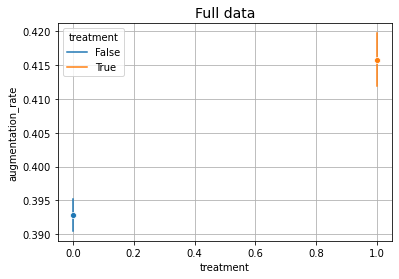

In [184]:

fig, ax = plt.subplots()
ax.set_title('Full data', fontsize=14)
_ = sns.lineplot(
    ax=ax,
    data=df, 
    x="treatment", y="augmentation_rate", 
    hue="treatment", 
    err_style="bars", 
    marker='o'
)
ax.grid()





Over all seems that suggestion from the new model (treatment=True) perform better than suggestions from old model (treatment=False). Given mean values and their standard deviations. 

Lets explore the data at the representative level.



### Counts per rep_id:

In [186]:

daux = df.groupby(['rep_id', 'treatment'])['augmentation_rate'].agg(['mean', 'std', 'count'])
daux = daux.unstack('treatment')
daux = daux.reorder_levels([1, 0], axis=1)
daux = daux[daux.columns.sort_values()]
daux



treatment  False                      True                     
           count      mean       std  count      mean       std
rep_id                                                         
250001     122.0  0.631604  0.121247  282.0  0.736670  0.132802
270001     203.0  0.224067  0.114574  312.0  0.297228  0.162708
340001     573.0  0.060151  0.082296    NaN       NaN       NaN
390001     184.0  0.442092  0.141475  337.0  0.562744  0.174622
430001     755.0  0.754637  0.156864    NaN       NaN       NaN
...          ...       ...       ...    ...       ...       ...
4660001    335.0  0.268121  0.147012    NaN       NaN       NaN
4670001      4.0  0.341071  0.163546  231.0  0.411353  0.183705
4680001    289.0  0.484842  0.198871    NaN       NaN       NaN
4690001      4.0  0.213005  0.078468  305.0  0.303120  0.165881
4700001      4.0  0.568601  0.077427    NaN       NaN       NaN

[135 rows x 6 columns]

In [232]:

print('rep_ids without 1st treatment data:', daux[daux[(False, 'count')].isna()].shape)
print('rep_ids without 2nd treatment data:', daux[daux[(True, 'count')].isna()].shape)



rep_ids without 1st treatment data: (1, 6)
rep_ids without 2nd treatment data: (73, 6)



**NOTE:** Some of the representatives were not exposed to both models. 1 representative were expose only to model B (treatment==True) while 73 representatives were exposed only to model A (treatment==False).

I decided to split the population in 3:

- set 1: Those representatives exposed to both models  (61 ids), 
- set 2: Those representatives exposed to only model A (73 ids).
- set 3: Those representatives exposed to only model B (1 id).

#### Whats the plan?
1. Determine if there is a statistical significance between both models in ids belonging to set 1.
2. Lets assume that the set 2 determines the mean value of the population and then compare with value "measured" from set 3. 




In [443]:
woTreatmentData = daux[(True, 'count')].isna()
# Ids without model B data
rep_ids_to_drop = daux[woTreatmentData].index.to_list()

dmap ={
    0:'OldTreatment and NewTreatment',
    1:'OldTreatment and no NewTreatment',
    2:'no OldTreatment and NewTreatment'
}

df['woTreatmentdata'] = df['rep_id'].isin(rep_ids_to_drop)
df['Cases'] = df[['treatment', 'woTreatmentdata']].apply(lambda x: dmap[int(2*x['treatment']+x['woTreatmentdata'])], axis=1)



In [451]:
#
dar = df.groupby(['treatment', 'woTreatmentdata'])['augmentation_rate'].agg(['mean', 'std', 'count'])
dar['%'] = dar['count']/ dar['count'].sum()
dar['meanSig'] = dar['std']/ np.sqrt(dar['count'])

print('- Counts at log level!')
dar



- Counts at log level!


mean       std  count         %   meanSig
treatment woTreatmentdata                                               
False     False            0.335846  0.252900   9968  0.144225  0.002533
          True             0.407300  0.268008  39403  0.570116  0.001350
True      False            0.415764  0.279259  19743  0.285658  0.001987

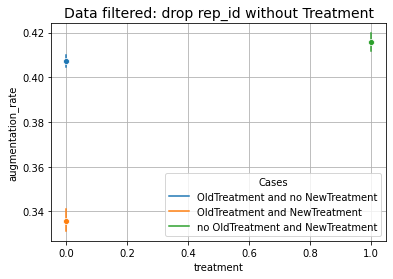

In [452]:
fig, ax = plt.subplots()
ax.set_title('Data filtered: drop rep_id without Treatment', fontsize=14)
_ = sns.lineplot(
    ax=ax,
    data=df, #[cond], 
    x="treatment", y="augmentation_rate", 
    hue="Cases", 
    err_style="bars", 
    marker='o'
)
ax.grid()

### Set 1: Representatives exposed to both models:

In [399]:

wBothTreatmentData = ~daux[(True, 'count')].isna() & ~daux[(False, 'count')].isna()
rep_ids_to_keep = daux[wBothTreatmentData].index.to_list()
cond = df['rep_id'].isin(rep_ids_to_keep)
print('treatment:')
print(df[cond]['treatment'].value_counts())



treatment:
True     19654
False     9968
Name: treatment, dtype: int64


In [400]:

dg = df[cond].groupby(['rep_id', 'treatment'])['augmentation_rate'].mean().unstack()
dg.columns = ['OldTreatment', 'NewTreatment']
dg['diff'] = dg['NewTreatment'] - dg['OldTreatment']
print(dg.describe())
dg.head(5)



       OldTreatment  NewTreatment       diff
count     61.000000     61.000000  61.000000
mean       0.351632      0.415795   0.064163
std        0.223739      0.228644   0.056793
min        0.044603      0.055429  -0.295238
25%        0.189928      0.245664   0.049462
50%        0.265086      0.338630   0.070282
75%        0.477001      0.571481   0.092547
max        0.910606      0.883572   0.144133


OldTreatment  NewTreatment      diff
rep_id                                      
250001      0.631604      0.736670  0.105066
270001      0.224067      0.297228  0.073161
390001      0.442092      0.562744  0.120652
480001      0.801055      0.850659  0.049603
540001      0.758034      0.827352  0.069318

In [401]:

# Same representatives different models/treatment:
res = st.ttest_1samp(dg['diff'], popmean=0, alternative='greater')
print(f"pValue: {res.pvalue}, statistic: {res.statistic.round(4)}")



pValue: 9.781974358412619e-13, statistic: 8.8237


### Interpretation:

We can conclude with almost 100% confidence that model B (treatment==True) produce an improvement in the augmentation rate. Given the difference in the mean value per representative is greater than 0 with almost 100% confidence.

```python
"""What about the discrepancy in volumen/size/number of logs data in model A and B?"""
```



In [380]:

# Non-null hypothesis: Looking for a minimum improvement...
for m in [0.03, 0.05, 0.051, 0.052, 0.053, 0.055, 0.06]:
    res = st.ttest_1samp(dg['diff'], popmean=m, alternative='greater')
    print(f"Aug.Rate.Improvement: {m:2.3f}, pValue: {res.pvalue:2.3%}, statistic: {res.statistic.round(3)}")



Aug.Rate.Improvement: 0.030, pValue: 0.001%, statistic: 4.698
Aug.Rate.Improvement: 0.050, pValue: 2.807%, statistic: 1.948
Aug.Rate.Improvement: 0.051, pValue: 3.764%, statistic: 1.81
Aug.Rate.Improvement: 0.052, pValue: 4.980%, statistic: 1.673
Aug.Rate.Improvement: 0.053, pValue: 6.500%, statistic: 1.535
Aug.Rate.Improvement: 0.055, pValue: 10.626%, statistic: 1.26
Aug.Rate.Improvement: 0.060, pValue: 28.456%, statistic: 0.572


We can conclude with 95% confidence that model B (treatmen=True) produce an improvement greater than 0.052 in the augmentation rate.
- pValue <5%

In [402]:

# #
# dg = df[cond].groupby(['rep_id', 'treatment'])['augmentation_rate'].agg(['mean', 'count', 'std']).unstack()
# dg.columns = ['OldTreatment', 'NewTreatment', 'old_count', 'new_count', 'old_std', 'new_std']
# dg['diff'] = dg['NewTreatment'] - dg['OldTreatment']
# dg.describe()

# dg.head(5)

In [396]:
# ==============================
# Why pvalue ~ 12% ??????
# ==============================
mean1, std1, nobs1 = dg['OldTreatment'].apply(['mean', 'std', 'count']).values#.round(4)
mean2, std2, nobs2 = dg['NewTreatment'].apply(['mean', 'std', 'count']).values#.round(4)
print(mean1, std1, nobs1)
print(mean2, std2, nobs2)

res = st.ttest_ind_from_stats(
    mean1, std1, nobs1, 
    mean2, std2, nobs2, equal_var=True, alternative='two-sided'
)
print(res)

# res = st.ttest_ind(dg['OldTreatment'], dg['NewTreatment'], equal_var=True, alternative='two-sided')
# print(res)

# --------------------
# 0.352 0.127 163.41
# 0.416 0.165 322.197
# --------------------
# 0.3516 0.2237 61.0
# 0.4158 0.2286 61.0
# --------------------

0.35163243379030296 0.22373917095251838 61.0
0.41579539651829983 0.22864369332689904 61.0
Ttest_indResult(statistic=-1.5665081435343526, pvalue=0.11986299749070763)


In [339]:

# Why this is not working? if I decided to compare data instead of differences...
print('Equal var case:', st.ttest_ind(dg['OldTreatment'], dg['NewTreatment'], equal_var=True))
print('Non Equal var case:', st.ttest_ind(dg['OldTreatment'], dg['NewTreatment'], equal_var=False))



Equal var case: Ttest_indResult(statistic=-1.5665081435343526, pvalue=0.11986299749070763)
Non Equal var case: Ttest_indResult(statistic=-1.5665081435343529, pvalue=0.11986423357893897)



**NOTES: we cannot conclude with at least 95% confidence that model B (treatment==True) is different from model A (treatment=False).**



### Step 2: Compare set 2 vs set1:

In [403]:

wModelATreatmentData = daux[(True, 'count')].isna() 
modelA_rep_ids = daux[wModelATreatmentData].index.to_list()
cond = df['rep_id'].isin(modelA_rep_ids)

print('Representatives exposed to Model A only:')
df[cond]['augmentation_rate'].describe()



Representatives exposed to Model A only:


count    39403.000000
mean         0.407300
std          0.268008
min          0.000000
25%          0.200000
50%          0.400000
75%          0.600000
max          1.000000
Name: augmentation_rate, dtype: float64

In [404]:
wModelBTreatmentData = daux[(False, 'count')].isna()
modelB_rep_ids = daux[wModelBTreatmentData].index.to_list()
print(len(modelB_rep_ids))
cond = df['rep_id'].isin(modelB_rep_ids)
# df[cond]['treatment'].value_counts()
df[cond]['augmentation_rate'].describe()


1


count    89.000000
mean      0.264461
std       0.183720
min       0.000000
25%       0.177778
50%       0.250000
75%       0.352941
max       1.000000
Name: augmentation_rate, dtype: float64

In [412]:

mean1, std1, nobs1 = df[df['rep_id'].isin(modelA_rep_ids)]['augmentation_rate'].apply(['mean', 'std', 'count']).values
mean2, std2, nobs2 = df[df['rep_id'].isin(modelB_rep_ids)]['augmentation_rate'].apply(['mean', 'std', 'count']).values 

print(mean1, std1, nobs1)
print(mean2, std2, nobs2)

res = st.ttest_ind_from_stats(
    mean1, std1, nobs1,
    mean2, std2, nobs2,
    equal_var=False, alternative='two-sided'
)
print(res)

res = st.ttest_ind_from_stats(
    mean1, std1, nobs1,
    mean2, std2, nobs2,
    equal_var=False, alternative='greater'
)
print(res)



0.4072995076133716 0.2680081179094418 39403.0
0.2644611785143176 0.18372025225033406 89.0
Ttest_indResult(statistic=7.317141963569781, pvalue=1.0762868856148313e-10)
Ttest_indResult(statistic=7.317141963569781, pvalue=5.3814344280741565e-11)


In [413]:

# def Zstatistic(z, m=0, s=1, v=0, tailed=1):
#     if tailed==1: 
#         p = st.norm.cdf(z, m, s)
#     elif tailed==2: 
#         z = abs(z)
#         p = st.norm.cdf(z, m, s) - st.norm.cdf(-z, m, s)
        
#     if v: 
#         print('Z:', z) #, )
#         print(f'Confidence: {p:2.2%}')
#         print(f'p-Value: {1-p:2.2%}')
        
#     return p.round(4)

# # If we asume the population mean and standard deviation
# mu0 = 0.407
# s0 = 0.268
# n = df[cond].shape[0]
# sigmean = s0/np.sqrt(n)
# print(f"n={n}, mu0:{mu0}, s0={s0}")

# # Sample mean:
# xmean = df[cond]['augmentation_rate'].mean()
# z = ((xmean - mu0)/sigmean).round(3)

# print('Z:', z)
# print()
# print('1 TAILED: (New method is best)')
# print(f'Confidence: {Zstatistic(z, tailed=1):2.2%}')
# print(f'p-Value: {1-Zstatistic(z, tailed=1):2.2%}')
# print()
# print('2 TAILED: results are different:')
# print(f'Confidence: {Zstatistic(z, tailed=2):2.2%}')
# print(f'p-Value: {1-Zstatistic(z, tailed=2):2.2%}')



In [189]:

# #
# woTreatmentData = daux[(True, 'count')].isna()
# rep_ids_to_drop = daux[woTreatmentData].index.to_list()
# # rep_ids_to_keep = daux[~woTreatmentData].index.to_list()
# cond = df['rep_id'].isin(rep_ids_to_drop)
# print(df[cond].shape)
# df[cond]['treatment'].value_counts()



(39403, 6)


False    39403
Name: treatment, dtype: int64

In [431]:

# # Condition to drop representatives without data for the New model.
# cond = ~df['rep_id'].isin(rep_ids_to_drop)
# dar = df[cond].groupby('treatment')['augmentation_rate'].agg(['mean', 'std', 'count'])
# dar['%'] = dar['count']/ dar['count'].sum()
# dar['meanSig'] = dar['std']/ np.sqrt(dar['count'])
# dar



In [432]:
# # Condition to drop representatives without data for the New model.
# cond = df['rep_id'].isin(rep_ids_to_drop)
# dar = df[cond].groupby('treatment')['augmentation_rate'].agg(['mean', 'std', 'count'])
# dar['%'] = dar['count']/ dar['count'].sum()
# dar['meanSig'] = dar['std']/ np.sqrt(dar['count'])
# dar

In [178]:

df.head(3)



start_time   rep_id  rep_sent_msgs  augmented_msgs  treatment  \
0 2018-10-15 04:35:36  1160001             12               1      False   
1 2018-10-15 04:34:33  4140001              8               3      False   
2 2018-10-15 04:24:53  4450001             13               2      False   

   augmentation_rate  
0           0.083333  
1           0.375000  
2           0.153846

In [ ]:

# Condition to drop representatives without data for the New model.
cond = ~df['rep_id'].isin(rep_ids_to_drop)
dar = df[cond].groupby('treatment')['augmentation_rate'].agg(['mean', 'std', 'count'])
dar['%'] = dar['count']/ dar['count'].sum()
dar['meanSig'] = dar['std']/ np.sqrt(dar['count'])
dar



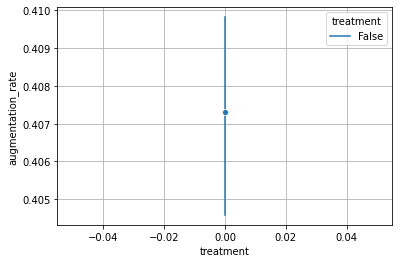

In [185]:

fig, ax = plt.subplots()

_ = sns.lineplot(
    ax=ax,
    data=df[~cond], 
    x="treatment", y="augmentation_rate", 
    hue="treatment", 
    err_style="bars", 
    marker='o'
)

ax.grid()



In [134]:

cond = ~df['rep_id'].isin(rep_ids_to_drop)

old_treatment = Treatment('Old Model')
new_treatment = Treatment('New Model')

old_treatment.mean, new_treatment.mean = df[cond].groupby('treatment')['augmentation_rate'].mean().round(3)
old_treatment.std, new_treatment.std = df[cond].groupby('treatment')['augmentation_rate'].std().round(3)
old_treatment.n, new_treatment.n = df[cond].groupby('treatment')['rep_id'].count().round(3)

print(old_treatment)
print(new_treatment)


Treatment(name='Old Model', mean=0.416, std=0.279, n=19743)
Treatment(name='New Model', mean=0.336, std=0.253, n=9968)


# How to quantify this results!?

In [92]:

#
daux.columns



MultiIndex([('New', 'count'),
            ('New',  'mean'),
            ('New',   'std'),
            ('Old', 'count'),
            ('Old',  'mean'),
            ('Old',   'std')],
           names=['treatment', None])

In [4]:

old_treatment = Treatment('Old Model')
new_treatment = Treatment('New Model')

old_treatment.mean, new_treatment.mean = df.groupby('treatment')['augmentation_rate'].mean()
old_treatment.std, new_treatment.std = df.groupby('treatment')['augmentation_rate'].std()
old_treatment.n, new_treatment.n = df.groupby('treatment')['rep_id'].count()



In [5]:
print(old_treatment)
print(new_treatment)

Treatment(name='Old Model', mean=0.39287298526374226, std=0.26657227340818085, n=49371)
Treatment(name='New Model', mean=0.4157643240208992, std=0.2792591231777621, n=19743)


In [11]:
tot = old_treatment.n + new_treatment.n
print(f"Old treatment data %: {old_treatment.n/tot:0.2%}")
print(f"New treatment data %: {new_treatment.n/tot:0.2%}")

Old tretment data %: 71.43%
New tretment data %: 28.57%


In [19]:
# Augmentation rates comparison:
s = df.groupby('treatment')['augmentation_rate'].std()
sm = df.groupby('treatment')['augmentation_rate'].mean()
print(s, sm)#, sn, s/np.sqrt(sn))

pd.DataFrame([s.values, sm.values], index=['std', 'mean'], columns=['Old Treatment', 'New Treatment'])



treatment
False    0.266572
True     0.279259
Name: augmentation_rate, dtype: float64 treatment
False    0.392873
True     0.415764
Name: augmentation_rate, dtype: float64


Old Treatment  New Treatment
std        0.266572       0.279259
mean       0.392873       0.415764

In [132]:
# T Statistic: Do models really different?
#------------------------------------



In [13]:

s = df.groupby('treatment')['augmentation_rate'].std()
sn = df.groupby('treatment')['rep_id'].count()
print(s)#, sn, s/np.sqrt(sn))



treatment
False    0.266572
True     0.279259
Name: augmentation_rate, dtype: float64


In [24]:

print(df['treatment'].value_counts().values)
print(df['treatment'].value_counts()/df.shape[0])



[49371 19743]
False    0.714342
True     0.285658
Name: treatment, dtype: float64


**NOTES:** 

0. Cases with treatment (new model) represents ~30% of the data.
1. With treatment (new model) mean augmentation rate is 0.416 (+/-0.002), without treatment (old model) it is 0.393 (+/-0.001).



In [12]:
df.dtypes

start_time        object
rep_id             int64
rep_sent_msgs      int64
augmented_msgs     int64
treatment           bool
dtype: object

In [15]:
dg = df.groupby('rep_id').agg({'rep_id': 'count', 'rep_sent_msgs': sum, 'augmented_msgs': sum, 'treatment': sum}).rename(columns={'rep_id': 'count'})
print(dg.shape)
dg

(135, 4)


count  rep_sent_msgs  augmented_msgs  treatment
rep_id                                                  
250001     404           8580            5944        282
270001     515           7850            1991        312
340001     573           7097             436          0
390001     521           8362            4258        337
430001     755           9925            7363          0
...        ...            ...             ...        ...
4660001    335           5828            1529          0
4670001    235           3873            1578        231
4680001    289           3726            1802          0
4690001    309           4657            1386        305
4700001      4            125              70          0

[135 rows x 4 columns]